<a href="https://colab.research.google.com/github/vieduy/CheXpert/blob/main/CheXpert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download datasets on kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"duyhoangvien","key":"63e4f0706f134b5483d8ef0e5c5e573c"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'xhlulu/vinbigdata-chest-xray-resized-png-256x256'

 99% 547M/550M [00:06<00:00, 88.8MB/s]
100% 550M/550M [00:06<00:00, 93.1MB/s]


In [ ]:
!unzip ./vinbigdata-chest-xray-resized-png-256x256.zip -d ./CheXpert-v1.0

In [ ]:
!nvidia-smi

Mon Feb 14 05:02:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import library

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os

In [ ]:
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim

import torchvision.transforms as transforms
import torchvision

from fastprogress import master_bar, progress_bar

from PIL import Image

In [ ]:
cd drive/MyDrive/CheXpert-v1.0

/content/drive/MyDrive/CheXpert-v1.0


In [ ]:
ls

densenet.pth  test/  test.csv  train/  train.csv  train_meta.csv  valid/


## Pre-processing train.csv

In [1]:
import pandas as pd

In [2]:
# read train.csv

df = pd.read_csv('train.csv')
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [3]:
# drop unnecessary fields

data = df[['image_id', 'class_id', 'rad_id']]
data

,image_id,class_id,rad_id
0,50a418190bc3fb1ef1633bf9678929b3,14,R11
1,21a10246a5ec7af151081d0cd6d65dc9,14,R7
2,9a5094b2563a1ef3ff50dc5c7ff71345,3,R10
3,051132a778e61a86eb147c7c6f564dfe,0,R10
4,063319de25ce7edb9b1c6b8881290140,14,R10
...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,14,R1
67910,ca7e72954550eeb610fe22bf0244b7fa,14,R1
67911,aa17d5312a0fb4a2939436abca7f9579,14,R8
67912,4b56bc6d22b192f075f13231419dfcc8,3,R8


In [4]:
# Drop duplicate rows

data.drop_duplicates(inplace = True)
data

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,image_id,class_id,rad_id
0,50a418190bc3fb1ef1633bf9678929b3,14,R11
1,21a10246a5ec7af151081d0cd6d65dc9,14,R7
2,9a5094b2563a1ef3ff50dc5c7ff71345,3,R10
3,051132a778e61a86eb147c7c6f564dfe,0,R10
4,063319de25ce7edb9b1c6b8881290140,14,R10
...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,14,R1
67910,ca7e72954550eeb610fe22bf0244b7fa,14,R1
67911,aa17d5312a0fb4a2939436abca7f9579,14,R8
67912,4b56bc6d22b192f075f13231419dfcc8,3,R8


In [ ]:
pathology = ['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration',
             'Lung Opacity', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis', 'No Finding']

In [ ]:
# combine class_id in one row if they have same image_id and rad_id

out = data.groupby(['image_id', 'rad_id'],as_index=False).agg({'class_id':list})
# out = out.join(pd.DataFrame(out.pop('class_id').tolist()))
out

,image_id,rad_id,class_id
0,000434271f63a053c4128a0ba6352c7f,R2,[14]
1,000434271f63a053c4128a0ba6352c7f,R3,[14]
2,000434271f63a053c4128a0ba6352c7f,R6,[14]
3,00053190460d56c53cc3e57321387478,R11,[14]
4,00053190460d56c53cc3e57321387478,R2,[14]
...,...,...,...
44995,fff0f82159f9083f3dd1f8967fc54f6a,R8,[14]
44996,fff0f82159f9083f3dd1f8967fc54f6a,R9,[14]
44997,fff2025e3c1d6970a8a6ee0404ac6940,R1,[14]
44998,fff2025e3c1d6970a8a6ee0404ac6940,R2,[14]


In [ ]:
labels = out.pop('class_id').tolist()
df2 = pd.DataFrame(columns=pathology)
df2

In [ ]:
import numpy as np

for i in range(len(labels)):
  dict_fill = dict(zip(np.array(pathology)[labels[i]], np.ones(len(labels[i]))))
  df2 = df2.append(dict_fill, ignore_index=True)

In [ ]:
result = pd.concat([out['image_id'], df2], axis=1)
result.head(100)

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
0,000434271f63a053c4128a0ba6352c7f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,000434271f63a053c4128a0ba6352c7f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,000434271f63a053c4128a0ba6352c7f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,00053190460d56c53cc3e57321387478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,00053190460d56c53cc3e57321387478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,00948e3e6acc03044af454fb9700ca60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
96,00958b3a4705cddb0d3d3b1a2c806f26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
97,00958b3a4705cddb0d3d3b1a2c806f26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
98,00958b3a4705cddb0d3d3b1a2c806f26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
result = result.fillna(0)

In [ ]:
result.to_csv('out.csv', index=False)

## Training model

In [ ]:
# read train.csv

data = pd.read_csv("./train.csv")
data

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
0,000434271f63a053c4128a0ba6352c7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00053190460d56c53cc3e57321387478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20707,ffe6f9fe648a7ec29a50feb92d6c15a4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20708,ffea246f04196af602c7dc123e5e48fc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20709,ffeffc54594debf3716d6fcd2402a99f,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20710,fff0f82159f9083f3dd1f8967fc54f6a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Get label names

LABELS = data.columns[1:]
LABELS

Index(['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly',
       'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass',
       'Other lesion', 'Pleural effusion', 'Pleural thickening',
       'Pneumothorax', 'Pulmonary fibrosis', 'No Finding'],
      dtype='object')

In [ ]:
# Split train-val

train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)

In [ ]:
class ChestXrayDataset(Dataset):
    
    def __init__(self, folder_dir, dataframe, image_size, normalization):
        """
        Init Dataset
        
        Parameters
        ----------
        folder_dir: str
            folder contains all images
        dataframe: pandas.DataFrame
            dataframe contains all information of images
        image_size: int
            image size to rescale
        normalization: bool
            whether applying normalization with mean and std from ImageNet or not
        """
        self.image_paths = [] 
        self.image_labels = []
        
        # Define list of image transformations
        image_transformation = [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ]
        
        if normalization:
            # Normalization with mean and std from ImageNet
            image_transformation.append(transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD))
        
        self.image_transformation = transforms.Compose(image_transformation)
        
        # Get all image paths and image labels from dataframe
        for index, row in dataframe.iterrows():
            image_path = os.path.join(folder_dir, 'train/'+row.image_id+'.png')
            self.image_paths.append(image_path)
            labels = []
            for col in row[1:]:
                if col == 1:
                    labels.append(1)
                else:
                    labels.append(0)
            self.image_labels.append(labels)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        """
        Read image at index and convert to torch Tensor
        """
        
        # Read image
        image_path = self.image_paths[index]
        image_data = Image.open(image_path).convert("RGB") # Convert image to RGB channels
        
        # Resize and convert image to torch tensor 
        image_data = self.image_transformation(image_data)
        
        return image_data, torch.FloatTensor(self.image_labels[index])

In [ ]:
IMAGE_SIZE = 224                              # Image size (224x224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]         # Mean of ImageNet dataset (used for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]          # Std of ImageNet dataset (used for normalization)
BATCH_SIZE = 96                              
LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 100

In [ ]:
train_dataset = ChestXrayDataset(".", train_data, IMAGE_SIZE, True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
val_dataset = ChestXrayDataset(".", val_data, IMAGE_SIZE, True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

### Init model

In [ ]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes, is_trained=True):
        """
        Init model architecture
        
        Parameters
        ----------
        num_classes: int
            number of classes
        is_trained: bool
            whether using pretrained model from ImageNet or not
        """
        super().__init__()
        
        # Load the DenseNet121 from ImageNet
        self.net = torchvision.models.densenet121(pretrained=is_trained)
        
        # Get the input dimension of last layer
        kernel_count = self.net.classifier.in_features
        
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        self.net.classifier = nn.Sequential(nn.Linear(kernel_count, num_classes), nn.Sigmoid())
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DenseNet121(num_classes=len(LABELS)).to(device)
model

In [ ]:
# Loss function
loss_criteria = nn.BCELoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)

# Learning rate will be reduced automatically during training
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = LEARNING_RATE_SCHEDULE_FACTOR, patience = LEARNING_RATE_SCHEDULE_PATIENCE, mode = 'max', verbose=True)

In [ ]:
!pip install fastprogress==0.1.20

  Attempting uninstall: fastprogress
    Found existing installation: fastprogress 1.0.0
    Uninstalling fastprogress-1.0.0:
      Successfully uninstalled fastprogress-1.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires fastprogress>=0.2.0, but you have fastprogress 0.1.20 which is incompatible.
fastai 1.0.61 requires fastprogress>=0.2.1, but you have fastprogress 0.1.20 which is incompatible.


In [ ]:
def multi_label_auroc(y_gt, y_pred):
    """ Calculate AUROC for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    auroc = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        auroc.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return auroc

In [ ]:
def epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb):
    """
    Epoch training

    Paramteters
    -----------
    epoch: int
      epoch number
    model: torch Module
      model to train
    train_dataloader: Dataset
      data loader for training
    device: str
      "cpu" or "cuda"
    loss_criteria: loss function
      loss function used for training
    optimizer: torch optimizer
      optimizer used for training
    mb: master bar of fastprogress
      progress to log

    Returns
    -------
    float
      training loss
    """
    # Switch model to training mode
    model.train()
    training_loss = 0 # Storing sum of training losses
   
    # For each batch
    for batch, (images, labels) in enumerate(progress_bar(train_dataloader, parent=mb)):
        
        # Move X, Y  to device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear previous gradient
        optimizer.zero_grad()

        # Feed forward the model
        pred = model(images)
        loss = loss_criteria(pred, labels)

        # Back propagation
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update training loss after each batch
        training_loss += loss.item()

        mb.child.comment = f'Training loss {training_loss/(batch+1)}'

    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    # return training loss
    return training_loss/len(train_dataloader)

In [ ]:
def evaluating(epoch, model, val_loader, device, loss_criteria, mb):
    """
    Validate model on validation dataset
    
    Parameters
    ----------
    epoch: int
        epoch number
    model: torch Module
        model used for validation
    val_loader: Dataset
        data loader of validation set
    device: str
        "cuda" or "cpu"
    loss_criteria: loss function
      loss function used for training
    mb: master bar of fastprogress
      progress to log
  
    Returns
    -------
    float
        loss on validation set
    float
        metric score on validation set
    """

    # Switch model to evaluation mode
    model.eval()

    val_loss = 0                                   # Total loss of model on validation set
    out_pred = torch.FloatTensor().to(device)      # Tensor stores prediction values
    out_gt = torch.FloatTensor().to(device)        # Tensor stores groundtruth values

    with torch.no_grad(): # Turn off gradient
        # For each batch
        for step, (images, labels) in enumerate(progress_bar(val_loader, parent=mb)):
            # Move images, labels to device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Update groundtruth values
            out_gt = torch.cat((out_gt,  labels), 0)

            # Feed forward the model
            ps = model(images)
            loss = loss_criteria(ps, labels)

            # Update prediction values
            out_pred = torch.cat((out_pred, ps), 0)

            # Update validation loss after each batch
            val_loss += loss
            mb.child.comment = f'Validation loss {val_loss/(step+1)}'

    # Clear memory
    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    # return validation loss, and metric score
    return val_loss/len(val_loader), np.array(multi_label_auroc(out_gt, out_pred)).mean()

### Training

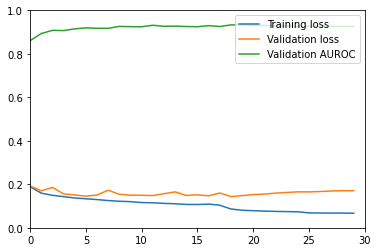

Epoch    18: reducing learning rate of group 0 to 1.0000e-04.
Epoch    25: reducing learning rate of group 0 to 1.0000e-05.


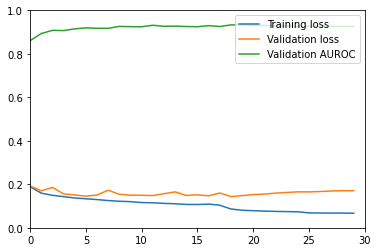

In [ ]:
import time

# Best AUROC value during training
best_score = 0
model_path = "densenet.pth"
training_losses = []
validation_losses = []
validation_score = []


# Config progress bar
mb = master_bar(range(MAX_EPOCHS))
mb.names = ['Training loss', 'Validation loss', 'Validation AUROC']
x = []

nonimproved_epoch = 0
start_time = time.time()

# Training each epoch
for epoch in mb:
    mb.main_bar .comment = f'Best AUROC score: {best_score}'
    x.append(epoch)

    # Training
    train_loss = epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb)
    mb.write('Finish training epoch {} with loss {:.4f}'.format(epoch, train_loss))
    training_losses.append(train_loss)

    # Evaluating
    val_loss, new_score = evaluating(epoch, model, val_dataloader, device, loss_criteria, mb)
    mb.write('Finish validation epoch {} with loss {:.4f} and score {:.4f}'.format(epoch, val_loss, new_score))
    validation_losses.append(val_loss)
    validation_score.append(new_score)

    # Update learning rate
    lr_scheduler.step(new_score)

    # Update training chart
    mb.update_graph([[x, training_losses], [x, validation_losses], [x, validation_score]], [0,epoch+1], [0,1])

    # Save model
    if best_score < new_score:
        mb.write(f"Improve AUROC from {best_score} to {new_score}")
        best_score = new_score
        nonimproved_epoch = 0
        torch.save({"model": model.state_dict(), 
                    "optimizer": optimizer.state_dict(), 
                    "best_score": best_score, 
                    "epoch": epoch, 
                    "lr_scheduler": lr_scheduler.state_dict()}, model_path)
    else: 
        nonimproved_epoch += 1
    if nonimproved_epoch > 10:
        break
        print("Early stopping")
    if time.time() - start_time > 3600*8:
        break
        print("Out of time")

## Testing

In [ ]:
test_df = pd.read_csv("./test.csv")
test_df.head()

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
0,test_1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
test_dataset = ChestXrayDataset(".", test_df, IMAGE_SIZE, True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
from tqdm import tqdm

out_pred = torch.FloatTensor().to(device)
with torch.no_grad(): # Turn off gradient
    # For each batch
    for step, (images, _) in tqdm(enumerate(test_dataloader)):
        # Move images, labels to device (GPU)
        images = images.to(device)

        # Feed forward the model
        ps = model(images)
        out_pred = torch.cat((out_pred, ps), dim=0)

1it [00:00,  8.40it/s]


In [ ]:
label_list = list(LABELS)
for col in test_df.columns[1:]:
    test_df[col] = out_pred[:, label_list.index(col)].cpu().numpy()

In [ ]:
test_df.head()

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
0,test_1,0.135018,0.008261,0.036882,0.752218,0.034592,0.289283,0.130301,0.444385,0.067186,0.317018,0.248082,0.577893,0.001068,0.021851,0.00019
